#Exploring Patterns of Population Structure and Environmental Associations to Aridity Across the Range of Loblolly Pine

##Introduction

In this set of analyses, we will be making use of data from the Eckert et al. 2010 paper to explore patterns of phenotypic and environmental associations among populations of loblolly pine.


###Abstract

Natural populations of forest trees exhibit striking phenotypic adaptations to diverse environmental
gradients, thereby making them appealing subjects for the study of genes underlying ecologically relevant phenotypes. Here, we use a genome-wide data set of single nucleotide polymorphisms genotyped across 3059 functional genes to study patterns of population structure and identify loci associated with aridity across the natural range of loblolly pine (Pinus taeda L.). Overall patterns of population structure, as inferred using principal components and Bayesian cluster analyses, were consistent with three genetic clusters likely resulting from expansions out of Pleistocene refugia located in Mexico and Florida. A novel application of association analysis, which removes the confounding effects of shared ancestry on correlations between genetic and environmental variation, identified five loci correlated with aridity. These loci were primarily involved with abiotic stress response to temperature and drought. A unique set of 24 loci was identified as FST outliers on the basis of the genetic clusters identified previously and after accounting for expansions out of Pleistocene refugia. These loci were involved with a diversity of physiological processes. Identification of nonoverlapping sets of loci highlights the fundamental differences implicit in the use of either method and suggests a pluralistic, yet complementary, approach to the identification of genes underlying ecologically relevant phenotypes.


##Overview of tasks

In general, what you will be doing is working your way from loading and saving data related to this study, to corrections for population structure, to looking for associations between genotypes and phenotypes, genotypes and the environment (`Bayenv2`), and genotypes+phenotypes+environment (`SQUAT`)

## This notebook

The goal of this notebook is to get set up and explore some basic patterns of the data.  At many of the steps, there is also a sanity check so that a quick view of the data (via the `head()` function of a `Pandas` dataframe).

As you work your way through these notebooks, please keep in mind that there are several things that are going on:

1. You are getting exposed to an amazing technology through the use of the IPython Notebook.
1. You are learning a little bit of Python.
1. You are getting familiar with the ways in which I actually do my analysis.
1. You are taking with you about 75% of the processes needed to publish GWAS results on your own.

####Let's begin

At the top of every notebook, there is a cell of code which sets up some basic functionality.  At this point, it's sufficient to just run the cell and move on.  If you want to know what things do, please ask.  

In [1]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
from hdfstorehelper import HDFStoreHelper
import warnings
import pandas
import dill
warnings.simplefilter("ignore", pandas.io.pytables.PerformanceWarning)
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

%load_ext autoreload
%autoreload 2

sns.set_context("talk")

####Execute the cell below to lead in the phenotype data

In [2]:
pheno = pd.read_excel("/gdc_home5/groups/congenomics/day5/landscape_genetics_data/Pinus_taeda_metabolite_data.xlsx", 
                      sheetname="metabolite_phenotype_data",
                      header=2)

####Let's look at all the traits in the file that contain the phrase, 'ose' (e.g., glucose, sucrose, etc.)

In [3]:
traits = [x for x in pheno.columns if "ose" in str(x)]
print traits

[u'glucose', u'fructose', u'sucrose', u'glucose-1-phosphate', u'maltose', u'xylose', u'inulotriose-1', u'raffinose', u'melibiose', u'arabinose', u'cellobiose', u'trehalose', u'melezitose']


####In the cell above, you should see the name of your new favorite metabolite.  Pick your favorite one, and set it's value in the cell.

For example, to set the `trait_name` variable to `maltose`, you could do one of the following:

* `trait_name = "maltose"`
* `trait_name = traits[4]`

After you set `trait_name` to your favorite one, execute the cell.  The notebook will also dump a file that we can use later across notebooks, which remember, are separate Python processes.

In [4]:
trait_name = "fructose"
dill.dump(trait_name, open("trait_name.dill", "w"))

####We need to tweak the phenotype data a bit for later analysis, so run this cell.

In [5]:
pheno = pheno[['Longitude', 'Latitude','Clone_id',trait_name]]
pheno.index = pheno.Clone_id
pheno = pheno.drop('Clone_id', axis=1)
pheno = pheno.astype(float)

####Have a peek a the the phenotype data.

In [6]:
pheno.head()

,Longitude,Latitude,fructose
Clone_id,,,
105A,-77.05205,35.55349,5.832140
109B,-76.93578,36.39002,5.628236
112C,-77.48749,35.06925,5.874419
118B,-78.29901,36.10041,5.841045
121C,-87.38771,34.14891,5.858395


####Load the rest of the data.  This will probably take a few minutes.

In [7]:
data_ai = pd.read_excel("/gdc_home5/groups/congenomics/day5/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx")
data_gt = pd.read_excel("/gdc_home5/groups/congenomics/day5/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx", 
                        sheetname="genotyping_data")
data_loc = pd.read_excel("/gdc_home5/groups/congenomics/day5/landscape_genetics_data/Genetics_2010/Eckert_Genetics_2010_data.xlsx",
                         sheetname="county_locality")

In [8]:
def add_county_state_key(df, c, s):
    d = df.copy()
    d['county_state'] = d.apply(lambda row: "%s_%s" % (row[c], row[s]), axis=1)
    return d

###The next three cells massage the data a bit more.

In [9]:
data_ai = add_county_state_key(data_ai, "County", "State")
data_ai.ix[:,0:2] = data_ai.ix[:,0:2].astype(str)
data_ai.ix[:,2:-1] = data_ai.ix[:,2:-1].astype(float)
data_ai.head()

,County,State,AI_Q1,AI_Q2,AI_Q3,AI_Q4,county_state
0,AIKEN,SC,5.310381,0.941023,0.774065,2.175380,AIKEN_SC
1,ANDERSON,SC,7.833872,1.034978,0.754804,2.920798,ANDERSON_SC
2,ANSON,NC,5.763893,0.889168,0.818064,2.488546,ANSON_NC
3,APPOMATTOX,VA,4.582158,0.840920,0.673995,2.740322,APPOMATTOX_VA
4,ASHLEY,AR,6.927071,1.191490,0.671492,3.429608,ASHLEY_AR


In [10]:
data_loc = add_county_state_key(data_loc, "county", "state")
data_loc.ix[:,0:2] = data_loc.ix[:,0:2].astype(str)
data_loc.ix[:,2:-1] = data_loc.ix[:,2:-1].astype(float)
data_loc.head()

,county,state,lat,long,county_state
0,CHEROKEE,GA,34.24000,-84.47000,CHEROKEE_GA
1,BARTOW,GA,34.24000,-84.84000,BARTOW_GA
2,SUSSEX,VA,36.92093,-77.28034,SUSSEX_VA
3,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA
4,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA


In [11]:
data_gt = data_gt.astype(str)
data_gt = add_county_state_key(data_gt, "county", "state")
data_gt.head()

,county,state,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,...,4033_01,4033_02,4056_01,4056_02,4058_01,4058_02,4093_01,4093_02,4112_01,4112_02,4137_01,4137_02,4181_01,4181_0,county_state
0,CHEROKEE,GA,G/G,A/C,G/G,A/A,G/G,A/G,A/A,G/G,A/C,A/A,A/A,A/A,A/A,...,131,143,413,413,143,150,307,310,462,462,161,161,365,390,CHEROKEE_GA
1,BARTOW,GA,A/A,C/C,G/G,A/A,G/G,A/G,A/A,A/G,A/A,G/G,A/A,A/A,A/A,...,?,?,413,437,137,143,307,307,440,448,161,176,365,365,BARTOW_GA
2,SUSSEX,VA,A/A,C/C,C/C,G/G,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/G,...,133,133,413,413,150,152,322,325,462,462,161,169,378,395,SUSSEX_VA
3,KING & QUEEN,VA,A/A,A/A,C/C,G/G,A/G,G/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,...,133,152,413,413,146,154,307,325,460,462,163,190,390,417,KING & QUEEN_VA
4,KING & QUEEN,VA,A/A,A/C,C/C,?/?,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,?/?,...,?,?,413,431,143,146,310,322,462,462,169,169,395,409,KING & QUEEN_VA


####We'll be using HDF5 to store our data across notebooks, in addition to the `dill` serialization above.

This is a widely used technology for large and hierarchical data sets, though we won't really be using it that way.  If you want, you can read more about this technology from [HDF5 themselves](http://www.hdfgroup.org/HDF5/) or [PyTables](https://pytables.github.io/usersguide/tutorials.html).  Run through these `.put()` cells to save the data out to disk for later use.

You may also be wondering about the `HDFStoreHelper` module.  I wrote that to save myself some time and safety for common HDF5 things.  Feel free to make it your own.

In [12]:
hdf = HDFStoreHelper("data.hd5")

In [13]:
hdf.put("pheno", pheno)

updating pheno


In [14]:
hdf.put("data_ai", data_ai)

updating data_ai


In [15]:
hdf.put("data_loc", data_loc)

updating data_loc


In [16]:
hdf.put("data_gt", data_gt)

updating data_gt


####Sometimes it's nice to have genotype data all by itself.  Let's filter our data down to just that by using the naming pattern in the columns of `data_gt`.

Run these cells to create the `DataFrame`, view a bit of it, and then save it to disk.

In [17]:
genotypes = data_gt.ix[:,[x for x in data_gt.columns if '-' in x]]

In [18]:
genotypes.head()

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,G/G,A/C,G/G,A/A,G/G,A/G,A/A,G/G,A/C,A/A,A/A,A/A,A/A,A/C,?/?,...,A/A,T/T,C/C,A/C,A/G,A/A,C/G,A/A,?/?,G/G,A/A,C/C,G/G,C/C,A/G
1,A/A,C/C,G/G,A/A,G/G,A/G,A/A,A/G,A/A,G/G,A/A,A/A,A/A,A/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,G/G,A/A,A/A,G/G,A/A,A/C,A/G,C/C,A/A
2,A/A,C/C,C/C,G/G,G/G,A/G,A/A,G/G,A/A,A/G,A/A,A/A,A/G,A/A,A/A,...,A/A,T/T,C/G,C/C,G/G,A/A,G/G,A/A,A/A,G/G,A/A,A/C,G/G,C/C,G/G
3,A/A,A/A,C/C,G/G,A/G,G/G,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,A/A,...,A/A,T/T,C/C,C/C,G/G,A/A,C/G,A/A,?/?,A/G,A/A,A/C,A/G,C/C,G/G
4,A/A,A/C,C/C,?/?,G/G,A/G,A/A,G/G,A/A,A/A,A/A,A/A,?/?,A/C,?/?,...,A/A,T/T,C/G,C/C,G/G,A/A,C/G,A/A,C/C,A/G,A/A,A/C,G/G,A/C,G/G


In [19]:
hdf.put("genotypes", genotypes)

updating genotypes


####Let's load up some functions to some work later.  I feel like even though they're not commented, it's still pretty readable what it does.  

Feel free to browse the code and ask questions.  Not all programmers are the same, so the way my brain works might not make sense to you.

In [20]:
def is_homozygous(gt):
    if len(set([x.strip() for x in gt.split("/")])) == 1:
        return True
    return False

def get_allele_counts(counts):
    a = {}
    het = 0
    for gt in counts.index:
        for allele in [x.strip() for x in gt.split("/")]:
            if not allele in a:
                a[allele] = 0
            a[allele] += counts[gt]
        if not is_homozygous(gt):
            het += counts[gt]
    return sorted(a.items(), key=lambda x: x[1], reverse=True), het

def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def get_allele_freqs(locus):
    locus = locus[locus != '?/?']
    locus = locus[locus != 'NA']
    c = locus.value_counts()
    c = c.sort(inplace=False, ascending=False)
    allele_counts = get_allele_counts(c)
    total_alleles = 2.0*sum(c)
    num_individuals = sum(c)
    A = ""
    a = ""
    P = 0
    Q = 0
    if len(allele_counts[0]) == 2:
        A = allele_counts[0][0][0]
        a = allele_counts[0][1][0]
        P = allele_counts[0][0][1]
        Q = allele_counts[0][1][1]
    else:
        A = allele_counts[0][0][0]
        P = P = allele_counts[0][0][1]
    PQ = allele_counts[-1]
    p = P/total_alleles
    q = Q/total_alleles
    assert p + q == 1.0
    He = 2 * p * q * get_correction(num_individuals)
    Ho = PQ*1.0/num_individuals
    Fis = 1 - (Ho/He)
    #print p, q, He, Ho, Fis
    ret = pd.Series({"p":p, 
                      "q":q,
                      "P":P,
                      "Q":Q,
                      "He":He,
                      "Ho":Ho, 
                      "Fis":Fis,
                    "PQ": PQ,
                    "total_alleles":total_alleles,
                    "num_indiv":num_individuals,
                    "A":A,
                    "a":a})
    return ret

def plot_hist(df, index):
    d = df.ix[index,:]
    plt.hist(d, bins=20)
    plt.title("%s %.2f $\pm$ %.3f [%.2f, %.2f]" % (index, 
                                                   np.mean(d), 
                                                   np.std(d),
                                                  np.min(d),
                                                  np.max(d)))
    
def convert_to_z12(locus):
    freq = af[locus.name]
    trans = {"%s/%s" % (freq["A"],freq["A"]): 0,
            "%s/%s" % (freq["a"],freq["a"]): 2,
            "%s/%s" % (freq["A"],freq["a"]): 1,
            "%s/%s" % (freq["a"],freq["A"]): 1,
            "?/?":-1}
    return locus.apply(lambda x: trans[x])

def center_and_standardize_value(val, u, var):
    if val == -1:
        return 0.0
    return (val-u)/np.sqrt(var)

def center_and_standardize(snp):
    maf = af.ix["q",snp.name]
    u = np.mean([x for x in snp if x != -1])
    var = np.sqrt(maf*(1-maf))
    return snp.apply(center_and_standardize_value, args=(u, var))

####This next set of cells does a few things:

1. Creates a `DataFrame` to hold some allele frequency data, saves it, and plots Fis from it.
1. Coverts the base/base genotypes into a 0/1/2 matrix, like the one you might get out of `vcftools`.  Note that 2's are the minor allele.  -1 represents missing data.
1. Takes the 012 file and applies normalization to it (subtracting the value form the mean genotype and dividing by the variance of the minor allele frequency)

In [21]:
af = genotypes.apply(get_allele_freqs)

In [22]:
af.head()

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
A,A,C,C,G,G,G,A,G,A,A,A,A,A,A,A,...,A,T,C,C,G,A,G,A,C,G,A,C,G,C,G
Fis,-0.03216907,0.02119724,0.09921339,0.1181548,0.03167254,0.05276604,0.04186125,0.003752806,-0.03022426,-0.05247644,0.04418605,0.1390307,0.01549163,0.08842149,0.1309751,...,0.08527132,0.0348086,-0.0378386,0.02560702,0.05450124,0.0450352,-0.08856421,-0.007317073,-0.03225219,0.06810505,-0.01142857,0.009112455,0.04806096,-0.0906287,0.01791584
He,0.4090983,0.4999238,0.5004262,0.450996,0.1261452,0.5003425,0.0779379,0.07471404,0.1083749,0.4411364,0.04747877,0.1645748,0.09610547,0.4252208,0.1117601,...,0.05642428,0.1912994,0.2870122,0.25657,0.2943773,0.09827706,0.3802323,0.01601187,0.4271409,0.1343534,0.02392017,0.3860135,0.4263844,0.2386665,0.3405494
Ho,0.4222586,0.4893268,0.4507772,0.3977087,0.1221498,0.4739414,0.07467532,0.07443366,0.1116505,0.4642857,0.04538088,0.1416938,0.09461664,0.3876221,0.0971223,...,0.0516129,0.1846405,0.2978723,0.25,0.2783333,0.09385113,0.4139073,0.01612903,0.4409171,0.1252033,0.02419355,0.3824959,0.405892,0.2602965,0.3344482
P,872,628,581,803,1145,621,1182,1188,1165,828,1204,1117,1164,852,1046,...,1204,1093,1010,1046,985,1172,900,1230,784,1141,1225,912,846,1046,936


In [23]:
hdf.put("af", af)

updating af


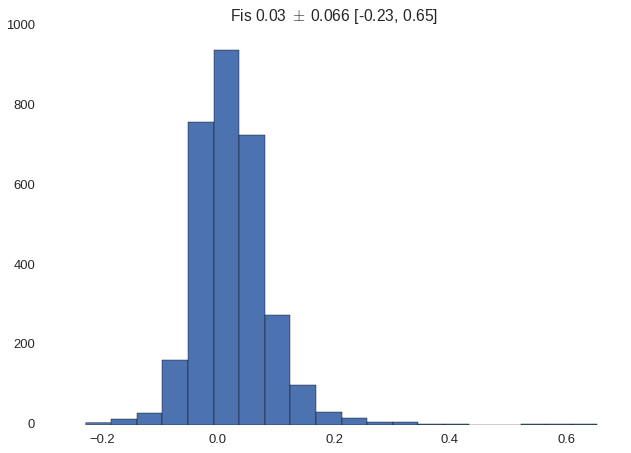

In [24]:
plot_hist(af, "Fis")

In [25]:
z12 = genotypes.apply(convert_to_z12)

In [26]:
hdf.put("z12", z12)

updating z12


In [27]:
pca_std = z12.apply(center_and_standardize)

In [28]:
hdf.put("pca_std", pca_std)

updating pca_std


In [29]:
z12.head()

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,2,1,2,2,0,1,0,0,1,0,0,0,0,1,-1,...,0,0,0,1,1,0,1,0,-1,0,0,0,0,0,1
1,0,0,2,2,0,1,0,1,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,0,0,1,1,0,2
2,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,2,0,0,1,0,0,0
3,0,2,0,0,1,0,0,0,0,1,0,0,0,2,0,...,0,0,0,0,0,0,1,0,-1,1,0,1,1,0,0
4,0,1,0,-1,0,1,0,0,0,0,0,0,-1,1,-1,...,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0


####This is the standardization from Patterson et al. 2006, I talked about in the lecture.

In [30]:
pca_std.head()

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,2.122583,0.044132,1.419103,1.907557,-0.269798,0.016123,-0.182725,-0.176704,1.834898,-0.957201,-0.123896,-0.337606,-0.216068,0.570954,0.000000,...,-0.141706,-0.38498,-0.563853,1.166627,1.036171,-0.220001,0.742318,-0.053932,0.000000,-0.284314,-0.073173,-0.787527,-0.905822,-0.470999,0.880073
1,-0.851954,-1.370426,1.419103,1.907557,-0.269798,0.016123,-0.182725,2.098366,-0.238168,1.961788,-0.123896,-0.337606,-0.216068,0.570954,-0.244204,...,-0.141706,-0.38498,-0.563853,-0.504634,-0.578641,-0.220001,-0.772412,-0.053932,2.034434,-0.284314,-0.073173,0.721492,0.566139,-0.470999,2.437126
2,-0.851954,-1.370426,-1.409333,-0.995350,-0.269798,0.016123,-0.182725,-0.176704,-0.238168,0.502294,-0.123896,-0.337606,1.920216,-0.902011,-0.244204,...,-0.141706,-0.38498,1.061214,-0.504634,-0.578641,-0.220001,-0.772412,-0.053932,2.034434,-0.284314,-0.073173,0.721492,-0.905822,-0.470999,-0.676979
3,-0.851954,1.458690,-1.409333,-0.995350,1.726054,-1.398136,-0.182725,-0.176704,-0.238168,0.502294,-0.123896,-0.337606,-0.216068,2.043918,-0.244204,...,-0.141706,-0.38498,-0.563853,-0.504634,-0.578641,-0.220001,0.742318,-0.053932,0.000000,1.680329,-0.073173,0.721492,0.566139,-0.470999,-0.676979
4,-0.851954,0.044132,-1.409333,0.000000,-0.269798,0.016123,-0.182725,-0.176704,-0.238168,-0.957201,-0.123896,-0.337606,0.000000,0.570954,0.000000,...,-0.141706,-0.38498,1.061214,-0.504634,-0.578641,-0.220001,0.742318,-0.053932,-0.908229,1.680329,-0.073173,0.721492,-0.905822,1.230764,-0.676979
